In [181]:
import time
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import stats
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [2]:
# params
seed = 42

In [3]:
#read the data
df = pd.read_csv('Loan Data.csv',
                 header = [0], sep = ';')

df.head()

,YOB,NKID,DEP,PHON,SINC,AES,DAINC,RES,DHVAL,DMORT,DOUTM,DOUTL,DOUTHP,DOUTCC,BAD
0,19.0,4.0,0.0,1,0.0,R,0.0,O,14464.0,4.0,0.0,0.0,0.0,0.0,0.0
1,41.0,2.0,0.0,1,0.0,P,36000.0,O,0.0,0.0,280.0,664.0,0.0,80.0,0.0
2,66.0,0.0,0.0,1,0.0,N,30000.0,N,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,51.0,2.0,0.0,1,0.0,P,464.0,O,24928.0,8464.0,584.0,320.0,0.0,60.0,0.0
4,65.0,0.0,0.0,1,0.0,P,15000.0,P,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1]:
#get description of factors as tabulated markdown
df_names = pd.read_excel('Loan Data Dictionary.xls', header = [2])
df_names = df_names.fillna("")
#print(df_names.to_markdown())

NameError: name 'pd' is not defined

### Список факторов:


|    | Variable Name                                                                               | Description                   | Codings                        |
|---:|:--------------------------------------------------------------------------------------------|:------------------------------|:-------------------------------|
|  0 |                                                                                             |                               |                                |
|  1 | yob                                                                                         | Year of birth                 | If unknown the year will be 99 |
|  2 | nkid                                                                                        | Number of children            | number                         |
|  3 | dep                                                                                         | Number of other dependents    | number                         |
|  4 | phon                                                                                        | Is there a home phone         | 1=yes, 0 = no                  |
|  5 | sinc                                                                                        | Spouse's income               |                                |
|  6 | aes                                                                                         | Applicant's employment status | V = Government                 |
|  7 |                                                                                             |                               | W = housewife                  |
|  8 |                                                                                             |                               | M = military                   |
|  9 |                                                                                             |                               | P = private sector             |
| 10 |                                                                                             |                               | B = public sector              |
| 11 |                                                                                             |                               | R = retired                    |
| 12 |                                                                                             |                               | E = self employed              |
| 13 |                                                                                             |                               | T = student                    |
| 14 |                                                                                             |                               | U = unemployed                 |
| 15 |                                                                                             |                               | N = others                     |
| 16 |                                                                                             |                               | Z  = no response               |
| 17 |                                                                                             |                               |                                |
| 18 |                                                                                             |                               |                                |
| 19 | dainc                                                                                       | Applicant's income            |                                |
| 20 | res                                                                                         | Residential status            | O = Owner                      |
| 21 |                                                                                             |                               | F = tenant furnished           |
| 22 |                                                                                             |                               | U = Tenant Unfurnished         |
| 23 |                                                                                             |                               | P = With parents               |
| 24 |                                                                                             |                               | N = Other                      |
| 25 |                                                                                             |                               | Z = No response                |
| 26 | dhval                                                                                       | Value of Home                 | 0 = no response or not owner   |
| 27 |                                                                                             |                               | 000001 = zero value            |
| 28 |                                                                                             |                               | blank = no response            |
| 29 | dmort                                                                                       | Mortgage balance outstanding  | 0 = no response or not owner   |
| 30 |                                                                                             |                               | 000001 = zero balance          |
| 31 |                                                                                             |                               | blank = no response            |
| 32 | doutm                                                                                       | Outgoings on mortgage or rent |                                |
| 33 | doutl                                                                                       | Outgoings on Loans            |                                |
| 34 | douthp                                                                                      | Outgoings on Hire Purchase    |                                |
| 35 | doutcc                                                                                      | Outgoings on credit cards     |                                |
| 36 | Bad                                                                                         | Good/bad indicator            | 1 = Bad                        |
| 37 |                                                                                             |                               | 0 = Good                       |


Для единообразия нотации, переименуем зависимую переменну из Bad в target

In [4]:
df.rename(columns = {"BAD":"target"}, inplace = True)

Выделяем test&train сеты

In [5]:
X = df.loc[:, df.columns != 'target']
y = df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)


Сохраняем данные

In [ ]:
!pip install pyarrow
!pip install fastparquet

In [15]:
# Save data & info ===
# parquet is optimized for large volumes of data
!mkdir samples
X_train.to_parquet('./samples/X_train.parquet')
X_test.to_parquet('./samples/X_test.parquet')
# переводим pd.Series в pd.DataFrame для удобного экспорта
pd.DataFrame(y_train).to_parquet('./samples/y_train.parquet')
pd.DataFrame(y_test).to_parquet('./samples/y_test.parquet')

#списки категориальных и количественных переменных
df_number_of_uniques = df.nunique()
presumably_continuous = df_number_of_uniques[df_number_of_uniques >= 15]
presumably_discrete = df_number_of_uniques[df_number_of_uniques < 15]

presumably_continuous_names = list(presumably_continuous.index)
presumably_discrete_names = list(presumably_discrete.index)

with open('factors.json', 'w') as f:
    json.dump({'cat_vals': presumably_discrete_names, "num_vals": presumably_continuous_names}, f)

A subdirectory or file samples already exists.


### Статистики

In [16]:
print(f'Количество наблюдений: {X.shape[0]}')
print(f'Количество факторов: {X.shape[1]}')
print(f'Количество целевых событий: {y.sum()}')
print(f'Доля целевых событий: {y.sum() / X.shape[0] * 100}%')

Количество наблюдений: 1225
Количество факторов: 14
Количество целевых событий: 323.0
Доля целевых событий: 26.36734693877551%


### Пропуски

Незаполненные пропуски в датасете отсутствуют:

In [30]:
for col in X.columns:
    print(f'Количество пропусков по фактору {col}:\n\t{X[col].isna().sum()} или {X[col].isna().sum() / df.shape[0] * 100}%')

Количество пропусков по фактору YOB:
	0 или 0.0%
Количество пропусков по фактору NKID:
	0 или 0.0%
Количество пропусков по фактору DEP:
	0 или 0.0%
Количество пропусков по фактору PHON:
	0 или 0.0%
Количество пропусков по фактору SINC:
	0 или 0.0%
Количество пропусков по фактору AES:
	0 или 0.0%
Количество пропусков по фактору DAINC:
	0 или 0.0%
Количество пропусков по фактору RES:
	0 или 0.0%
Количество пропусков по фактору DHVAL:
	0 или 0.0%
Количество пропусков по фактору DMORT:
	0 или 0.0%
Количество пропусков по фактору DOUTM:
	0 или 0.0%
Количество пропусков по фактору DOUTL:
	0 или 0.0%
Количество пропусков по фактору DOUTHP:
	0 или 0.0%
Количество пропусков по фактору DOUTCC:
	0 или 0.0%


Однако согласно описанию переменных, в некоторых из них пропущенные данные были заполнены различными числами. Доля этих чисел:

In [34]:
print(f'Количество пропусков по фактору YOB:\n\t{(X["YOB"] == 99).sum()} или {(X["YOB"] == 99).sum() / df.shape[0] * 100}%')
print(f'Количество пропусков (no response) по фактору AES:\n\t{(X["AES"] == "Z").sum()} или {(X["AES"] == "Z").sum() / df.shape[0] * 100}%')
print(f'Количество пропусков (no response) по фактору RES:\n\t{(X["RES"] == "Z").sum()} или {(X["RES"] == "Z").sum() / df.shape[0] * 100}%')


Количество пропусков по фактору YOB:
	7 или 0.5714285714285714%
Количество пропусков (no response) по фактору AES:
	8 или 0.653061224489796%
Количество пропусков (no response) по фактору RES:
	0 или 0.0%


Нужно отметить, что для факторов AES и RES значение no response не является пропуском в чисто техническом смысле - данные есть, просто они сообщают, что респондент отказался отвечатьcat_vals_mask

### Визуальный анализ

Изготовим маску для осмысленного наименования факторов:

In [102]:
from pprint import pprint 
df_names_short = df_names[["Variable Name", "Description"]][(df_names["Variable Name"] != "")&(df_names["Description"] != "")]
short_names = df_names_short["Variable Name"]
short_names = short_names.str.upper()
meaningful_names = df_names_short["Description"]
names_mask = dict(zip(short_names, meaningful_names))

pprint(names_mask)

{'AES': "Applicant's employment status",
 'BAD': 'Good/bad indicator',
 'DAINC': "Applicant's income",
 'DEP': 'Number of other dependents',
 'DHVAL': 'Value of Home',
 'DMORT': 'Mortgage balance outstanding',
 'DOUTCC': 'Outgoings on credit cards',
 'DOUTHP': 'Outgoings on Hire Purchase',
 'DOUTL': 'Outgoings on Loans',
 'DOUTM': 'Outgoings on mortgage or rent',
 'NKID': 'Number of children',
 'PHON': 'Is there a home phone',
 'RES': 'Residential status',
 'SINC': "Spouse's income",
 'YOB': 'Year of birth'}


И маски для осмысленных обозначений кодов категориальных переменных (так как один и тот же код для разных факторов обозначает разные вещи, это будут разные списки):

In [86]:

cat_vals_phon_mask = {
    1 : "yes",
    0 : "no"
}
cat_vals_aes_mask = {
    "V" : "Government",
    "W" : "housewife",
    "M" : "military", 
    "P" : "private sector",
    "B" : "public sector",
    "R" : "retired",
    "E" : "self employed",
    "T" : "student",
    "U" : "unemployed",
    "N" : "others",
    "Z" : "no response"
}
cat_vals_res_mask = {
    "O" : "Owner", 
    "F" : "tenant furnished", 
    "U" : "Tenant Unfurnished", 
    "P" : "With parents", 
    "N" : "Other", 
    "Z" : "no response"
}

cat_vals_dhval_mask = {
    0 : "no response or not owner", 
    "" : "no response", 
    "000001" : "zero value"
}

cat_vals_dmort_mask = {
    0 : "no response or not owner", 
    "" : "no response", 
    "000001" : "zero value"
}

dict_of_masks = {
    "PHON" : cat_vals_phon_mask,
    "AES" : cat_vals_aes_mask,
    "RES" : cat_vals_res_mask,
    "DHVAL" : cat_vals_dhval_mask,
    "DMORT" : cat_vals_dmort_mask,
}

In [ ]:
X_cat = X.replace(cat_vals_phon_mask)

In [88]:
for col_name in dict_of_masks.keys():
    X_cat[col_name] = X_cat[col_name].replace(dict_of_masks[col_name])

In [90]:
X_cat.head()

,YOB,NKID,DEP,PHON,SINC,AES,DAINC,RES,DHVAL,DMORT,DOUTM,DOUTL,DOUTHP,DOUTCC
0,19.0,4.0,0.0,yes,0.0,retired,0.0,Owner,14464.0,4.0,0.0,0.0,0.0,0.0
1,41.0,2.0,0.0,yes,0.0,private sector,36000.0,Owner,no response or not owner,no response or not owner,280.0,664.0,0.0,80.0
2,66.0,0.0,0.0,yes,0.0,others,30000.0,Other,no response or not owner,no response or not owner,0.0,0.0,0.0,0.0
3,51.0,2.0,0.0,yes,0.0,private sector,464.0,Owner,24928.0,8464.0,584.0,320.0,0.0,60.0
4,65.0,0.0,0.0,yes,0.0,private sector,15000.0,With parents,no response or not owner,no response or not owner,0.0,0.0,0.0,0.0


Проверим, не осталось ли нулей или единиц из-за путаницы в типах данных (все ок):

In [100]:
print(X_cat["PHON"][X_cat["PHON"] == "0"])
print(X_cat["PHON"][X_cat["PHON"] == "1"])
print(X_cat["DHVAL"][X_cat["DHVAL"] == "0"])
print(X_cat["DHVAL"][X_cat["DHVAL"] == 0])
print(X_cat["DMORT"][X_cat["DMORT"] == "0"])

Series([], Name: PHON, dtype: object)
Series([], Name: PHON, dtype: object)
Series([], Name: DHVAL, dtype: object)
Series([], Name: DHVAL, dtype: object)
Series([], Name: DMORT, dtype: object)


In [170]:
X_cat = X_cat[X_cat["YOB"] != 99]

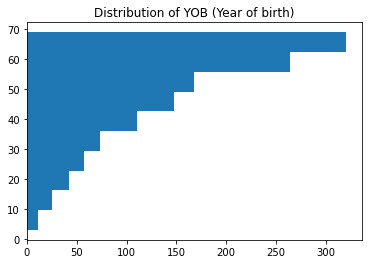

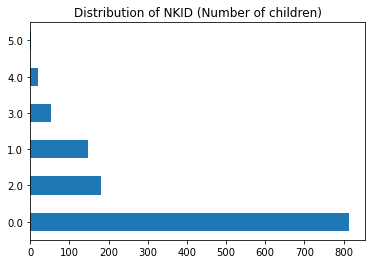

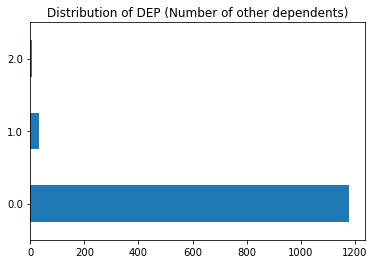

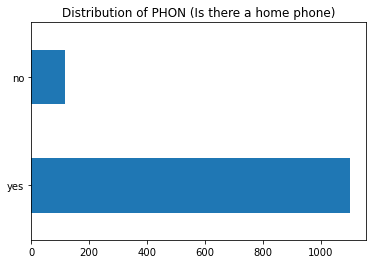

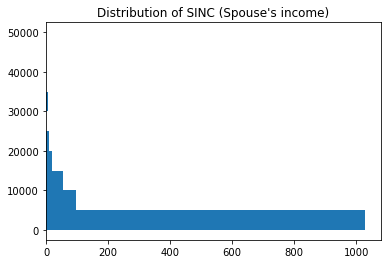

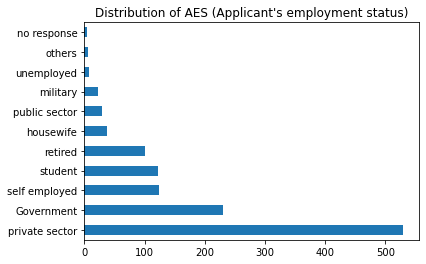

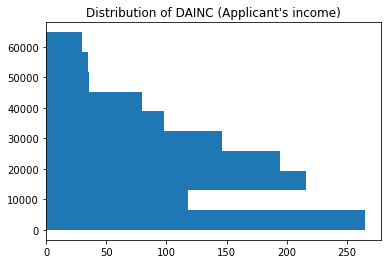

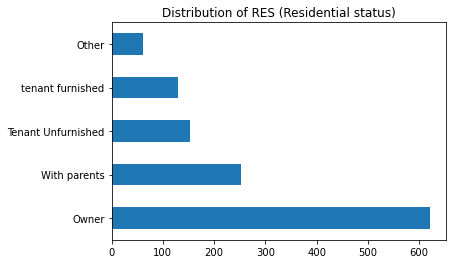

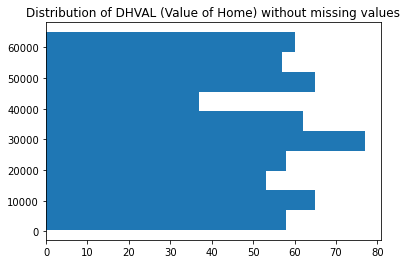

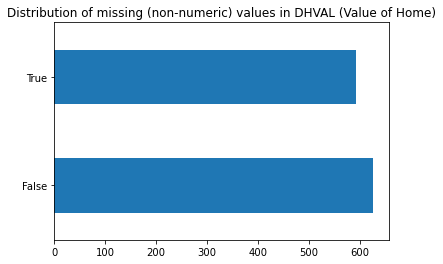

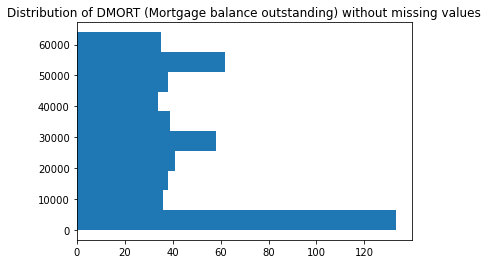

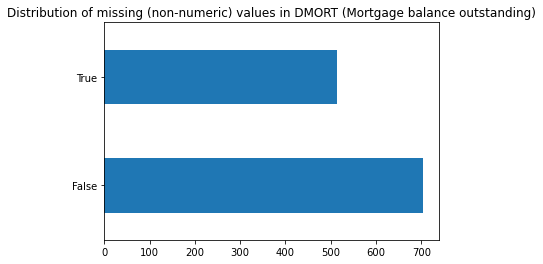

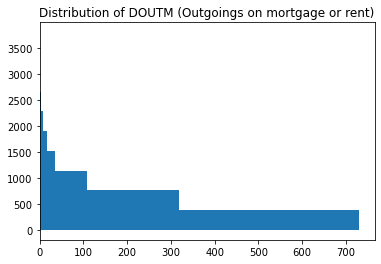

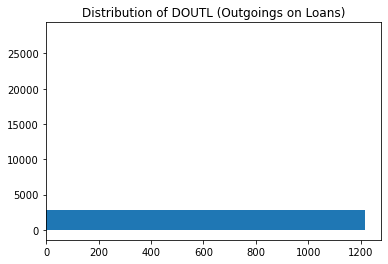

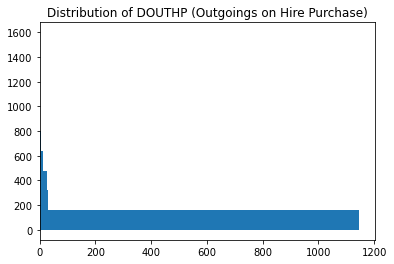

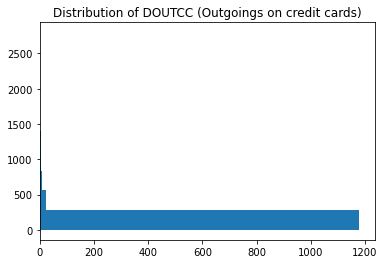

In [251]:
def plot_categorical(column, column_name, names_mask):
    column.value_counts().plot.barh()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_mixed(column, column_name, names_mask):
    print("This is a column mixed of both numeric and non-numeric values")
    check_numeric = column.str.isnumeric()
    check_numeric[check_numeric.isnull()] = True
    check_numeric[column.isnull()] = False

    plt.hist(column[check_numeric], orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]}) without non-numeric values')
    plt.show()

    check_numeric.value_counts().plot.barh()
    plt.title(f'Distribution of non-missing (numeric) values in {column_name} ({names_mask[column_name]})')
    plt.show()

def plot_numeric(column, column_name, names_mask):
    plt.hist(column, orientation='horizontal')
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()    

def plot_datetime(column, column_name, names_mask):
    column.hist()
    plt.title(f'Distribution of {column_name} ({names_mask[column_name]})')
    plt.show()
    
def check_mixed_or_categorical(column):
    if is_string_dtype(column) == False:
        return(False)
    else:
        check_numeric = column.str.isnumeric()
        check_numeric[check_numeric.isnull()] = True
        check_numeric[column.isnull()] = False
        if len(column[check_numeric]) == 0:
            return("categorical")
        else:
            return("mixed")

def check_factor_plotting_type(column, column_name, names_mask):
    if column.dtype == pd.Series([np.datetime64("1995-05-05")]).dtype:
        return("datetime")
    elif check_mixed_or_categorical(column) != False:
        return(check_mixed_or_categorical(column))
    else:
        return("numeric")

def plot_all(column, column_name, names_mask, presumably_discrete_names = presumably_discrete_names):
    map_functions_to_types = {
        "categorical" : plot_categorical,
        "mixed" : plot_mixed,
        "numeric" : plot_numeric, 
        "datetime" : plot_datetime
    }
    
    type_checked = check_factor_plotting_type(column, column_name, names_mask)
    print(type_checked)
    map_functions_to_types[type_checked](column, column_name, names_mask)



В первую очередь, смущает распределение годов рождения (самый первый график). Заявки от граждан, родившихся в 00-10х гг.? На момент публикации книги (2002) им было по 90-100 лет. Допустим, датасет собирался не одно десятилетие, но и в 80 подавать заявку на ипотеку как то подозрительно. Но допустим, бодрые пенсионеры. 

Куда больше внимания уделим графикам DOUTL, DOUTHP, DOUTCC и, немного в меньшей степени, DOUTM и SINC. Там явно есть аутлаеры. Это видно и из следующих графиков.

### Выбросы

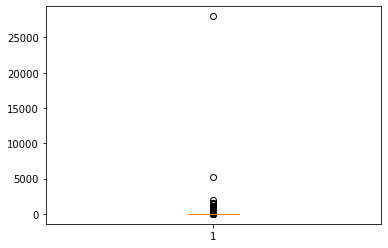

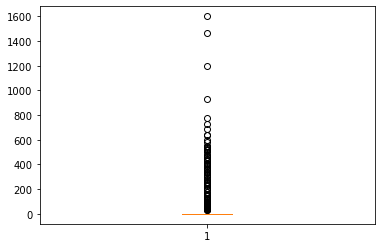

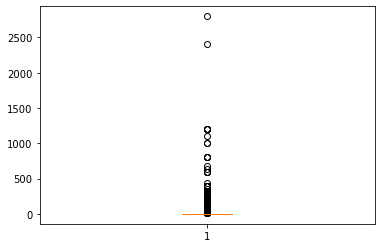

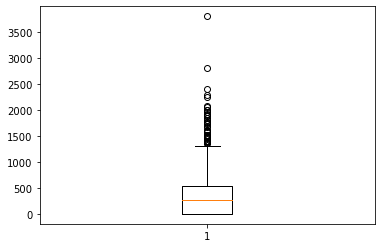

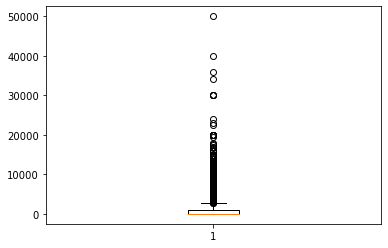

In [244]:
plt.boxplot(X_cat["DOUTL"])
plt.show()

plt.boxplot(X_cat["DOUTHP"])
plt.show()

plt.boxplot(X_cat["DOUTCC"])
plt.show()

plt.boxplot(X_cat["DOUTM"])
plt.show()

plt.boxplot(X_cat["SINC"])
plt.show()

Пробуем их идентифицировать и убрать используя z-score. Видим, что, во-первых, аутлаеры не очень многочислены (в среднем около процента в каждом из подозрительных столбцов), но при этом настолько велики, что в сумме весят до половины суммы значений в кажом из факторов. При этом выбрасывая их, мы почему-то не получаем существенных улучшений на графиках (вместо старой структуры с аутлаерами возникает новая, однородной выборки достичь не получается). 



Share of outliers in SINC (Outgoings on Loans) is 0.0016420361247947435
Mass of outliers in SINC (Outgoings on Loans) is 0.2222817354043921


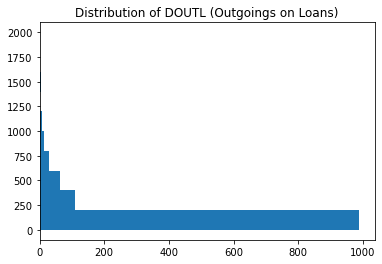

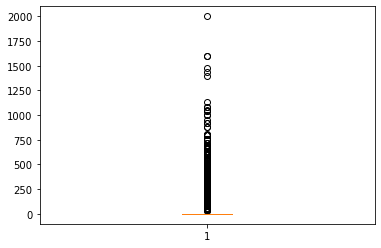



Share of outliers in SINC (Outgoings on mortgage or rent) is 0.017241379310344862
Mass of outliers in SINC (Outgoings on mortgage or rent) is 0.10373280943025542


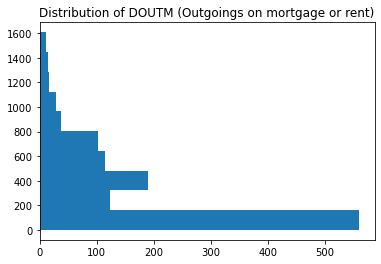

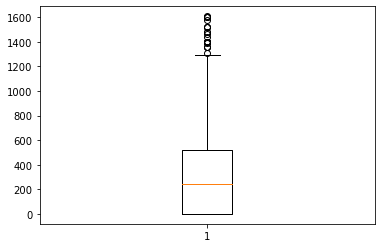



Share of outliers in SINC (Outgoings on credit cards) is 0.016420361247947435
Mass of outliers in SINC (Outgoings on credit cards) is 0.4529929126462301


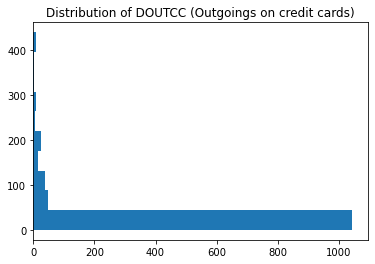

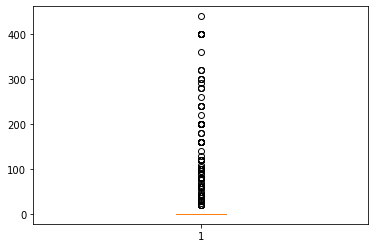



Share of outliers in SINC (Outgoings on Hire Purchase) is 0.028735632183908066
Mass of outliers in SINC (Outgoings on Hire Purchase) is 0.595043201455207


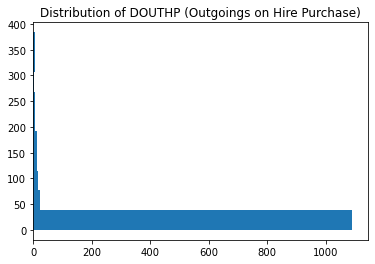

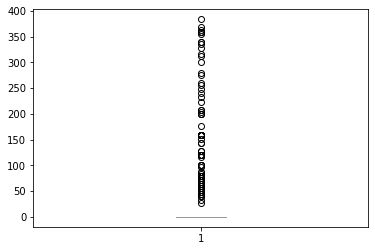



Share of outliers in SINC (Spouse's income) is 0.02052545155993435
Mass of outliers in SINC (Spouse's income) is 0.25253421812571697


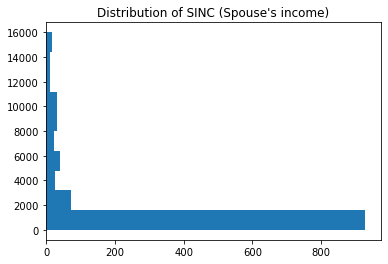

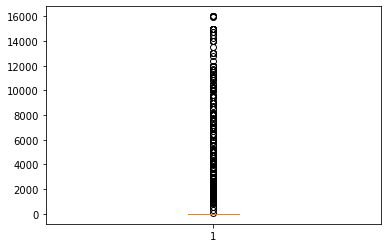

In [270]:
objects_with_outliers = ["DOUTL", "DOUTM", "DOUTCC", "DOUTHP", "SINC"]

for column_with_outliers_name in objects_with_outliers:
    object_without_outliers = X_cat[column_with_outliers_name][stats.zscore(X_cat[column_with_outliers_name]) < 3]
    print(f"\n\nShare of outliers in {column_with_outliers} ({names_mask[column_with_outliers_name]}) is {1 - len(object_without_outliers) / X_cat.shape[0]}")
    print(f"Mass of outliers in {column_with_outliers} ({names_mask[column_with_outliers_name]}) is {1 - (object_without_outliers.sum()) / X_cat[column_with_outliers_name].sum()}")
    
    plot_all(object_without_outliers, column_with_outliers_name, names_mask)
    
    plt.boxplot(object_without_outliers)
    plt.show()

### Выводы

Датасет совсем небольшой, как с точки зрения числа наблюдений, так и с точки зрения разнообразия факторов. Несколько числовых факторов демонстрируют значительные выбросы. Немного странное распределение годов рождения заемщиков. Решение заменить отсутствующие данные годом "99" кажется не очень верным, потому что при использовании переменной в модели за этим придется тщательно следить, к тому же сегодня люди 99-го года рождения уже могут подавать заявки на кредит. 